In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch

#### Define the linear dynamic system

In [4]:
from DynamicSystem import Linear_Dynamic_System
import os
import numpy.random as nrd
from MOR import AE_Reduced_System, POD_Reduced_System
import numpy as np
from util import mse

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# define the dimension of the system
dim_x = 50 # dimension of inate state
dim_y = 1 # dimension of output
dim_u = 5 # dimention of input
time_steps = 5000 # time steps to be generated
dim_x_reduct = 10 # dimension after MOR


original_sys = Linear_Dynamic_System(dim_x, dim_u, dim_y) # define a system


# randomly generate the input u and x0
u = np.random.randn(dim_u, time_steps)
x0 = np.random.randn(dim_x, 1)

# generate data
x, y = original_sys.gen(x0, u, time_steps)
print("the shape of x: ", x.shape)
print("the shape of y: ", y.shape)

the shape of x:  (50, 5000)
the shape of y:  (1, 5000)


In [9]:
import importlib
import MOR

In [100]:
ae_sys = AE_Reduced_System(original_sys, dim_x_reduct, nonlinear=True)
reconst_x_AE, reconst_y_AE = ae_sys.fit(x)

# import importlib
# import MOR
# importlib.reload(MOR)

pod_sys = MOR.POD_Reduced_System(original_sys, dim_x_reduct)
reconst_x_POD, reconst_y_POD = pod_sys.fit(x)

#### Prediction on training set with AE and POD

In [101]:
# training set

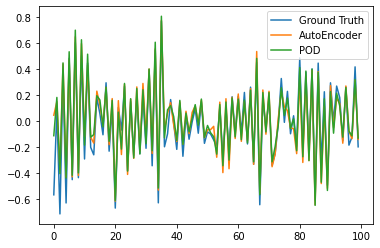

In [102]:
plt.plot(y.reshape(-1)[:100], label="Ground Truth")
plt.plot(reconst_y_AE.reshape(-1)[:100], label="AutoEncoder")
plt.plot(reconst_y_POD.reshape(-1)[:100], label='POD')
plt.legend()

In [103]:
mse(reconst_y_AE, y)

0.0037618513379444026

In [104]:
mse(reconst_y_POD, y)

0.0028331386027961036

<Figure size 10000x10000 with 0 Axes>

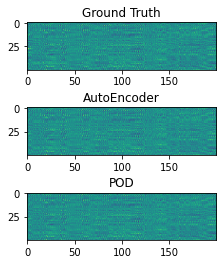

In [105]:
plt.figure(figsize=(100, 100), dpi=100)
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(x[:, :200], vmin=-2, vmax=2)
ax1.set_title("Ground Truth")
ax2.imshow(reconst_x_AE[:, :200], vmin=-2, vmax=2)
ax2.set_title("AutoEncoder")
ax3.imshow(reconst_x_POD[:, :200], vmin=-2, vmax=2)
ax3.set_title("POD")
plt.subplots_adjust(hspace=0.8)
plt.savefig("rec_x.png", dpi=100)

In [106]:
mse(reconst_x_POD, x), mse(reconst_x_AE, x)

(0.0076738996663572165, 0.0075905069464173875)

#### Prediction on test set

In [107]:
# test set

In [108]:
u_test = np.random.randn(dim_u, time_steps)
true_x = np.random.randn(dim_x)


In [109]:
def get_test_sets(x0, u_test, original_sys, time_steps): 
    true_xs, true_ys = [], []
    true_x = x0
    for i in range(time_steps):
        true_x, true_y = original_sys.step(true_x, u_test[:, i])
        true_ys.append(true_y[0])
        true_xs.append(true_x)
    true_xs = np.stack(true_xs).T
    true_ys = np.array(true_ys)
    return true_xs, true_ys


def get_test_predict(x0, u_test, reduction_sys, time_steps):
    new_x = reduction_sys.compress(x0)
    pred_xs, pred_ys = [], []
    for i in range(time_steps):
        new_x, new_y = reduction_sys.step(new_x, u_test[:, i])
        # print(true_y.shape, new_y.shape)
        pred_ys.append(new_y[0])
        pred_xs.append(reduction_sys.decompress(new_x))
    pred_xs = np.stack(pred_xs).T
    pred_ys = np.array(pred_ys)
    return pred_xs, pred_ys

In [110]:
true_xs, true_ys = get_test_sets(true_x, u_test, original_sys, time_steps)

In [111]:
ae_xs, ae_ys = get_test_predict(true_x, u_test, ae_sys, time_steps)
pod_xs, pod_ys = get_test_predict(true_x, u_test, pod_sys, time_steps)

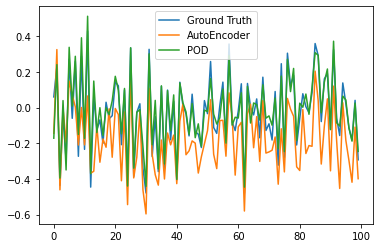

In [112]:
plt.plot(true_ys[:100], label="Ground Truth")
plt.plot(ae_ys[:100], label="AutoEncoder")
plt.plot(pod_ys[:100], label="POD")
plt.legend()

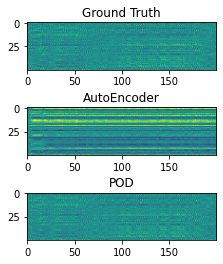

In [114]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(true_xs[:, :200], vmin=-2, vmax=2)
ax1.set_title("Ground Truth")
ax2.imshow(ae_xs[:, :200], vmin=-2, vmax=2)
ax2.set_title("AutoEncoder")
ax3.imshow(pod_xs[:, :200], vmin=-2, vmax=2)
ax3.set_title('POD')
plt.subplots_adjust(hspace=0.8)
plt.savefig("pre_x.png", dpi=100)

In [116]:
mse(true_xs, ae_xs), mse(true_xs, pod_xs)

(1.9651875390326579, 0.010217258411733982)

In [117]:
mse(true_ys, ae_ys), mse(true_ys, pod_ys)

(0.05487335232845032, 0.0034020919665372724)

#### Try AE without nonlinearity

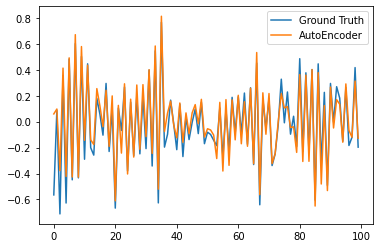

In [52]:
linear_ae_sys = AE_Reduced_System(original_sys, dim_x_reduct, nonlinear=False)
reconst_x_linear_AE, reconst_y_linear_AE = linear_ae_sys.fit(x)

plt.plot(y.reshape(-1)[:100], label="Ground Truth")
plt.plot(reconst_y_linear_AE.reshape(-1)[:100], label="AutoEncoder")
plt.legend()
# training

Text(0.5, 1.0, 'AutoEncoder')

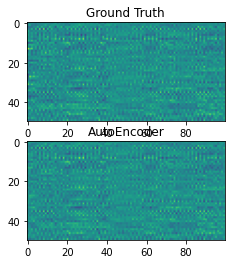

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(x[:, :100], vmin=-2, vmax=2)
ax1.set_title("Ground Truth")
ax2.imshow(reconst_x_linear_AE[:, :100], vmin=-2, vmax=2)
ax2.set_title("AutoEncoder")

In [56]:
linear_ae_xs, linear_ae_ys = get_test_predict(true_x, u_test, linear_ae_sys, time_steps)

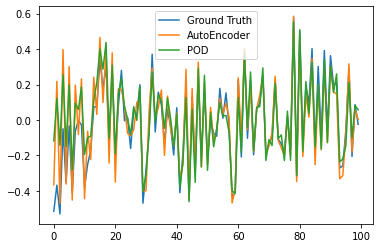

In [57]:
plt.plot(true_ys[:100], label="Ground Truth")
plt.plot(linear_ae_ys[:100], label="AutoEncoder")
plt.plot(pod_ys[:100], label="POD")
plt.legend()

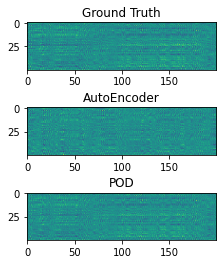

In [118]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(true_xs[:, :200], vmin=-2, vmax=2)
ax1.set_title("Ground Truth")
ax2.imshow(linear_ae_xs[:, :200], vmin=-2, vmax=2)
ax2.set_title("AutoEncoder")
ax3.imshow(pod_xs[:, :200], vmin=-2, vmax=2)
ax3.set_title('POD')
plt.subplots_adjust(hspace=0.8)
plt.savefig("nonlinear_x.png", dpi=100)

#### MSE change alongside different reduction dimension

In [7]:
u_test = np.random.randn(dim_u, time_steps)
true_x = np.random.randn(dim_x)
true_xs, true_ys = get_test_sets(true_x, u_test, original_sys, time_steps)

In [10]:
from tqdm import tqdm
dim_x_reduct_list = [1, 2, 4, 8, 16]

mse_train_list_x_pod = []
mse_test_list_x_pod = []
mse_train_list_y_pod = []
mse_test_list_y_pod = []

# with nonlinearity
for dim_reduc in tqdm(dim_x_reduct_list):
    pod_sys = MOR.POD_Reduced_System(original_sys, dim_reduc)
    reconst_x_POD, reconst_y_POD = pod_sys.fit(x)
    mse_train_list_y_pod.append(mse(y, reconst_y_POD))
    mse_train_list_x_pod.append(mse(x, reconst_x_POD))

    pod_xs, pod_ys = get_test_predict(true_x, u_test, pod_sys, time_steps)
    mse_test_list_x_pod.append(mse(true_xs, pod_xs))
    mse_test_list_y_pod.append(mse(true_ys, pod_ys))


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


In [14]:
mse_train_list_x_ae = []
mse_test_list_x_ae = []
mse_train_list_y_ae = []
mse_test_list_y_ae = []

# with nonlinearity
for dim_reduc in tqdm(dim_x_reduct_list):
    ae_sys = AE_Reduced_System(original_sys, dim_reduc, nonlinear=True)
    reconst_x_AE, reconst_y_AE = ae_sys.fit(x)
    mse_train_list_y_ae.append(mse(y, reconst_y_AE))
    mse_train_list_x_ae.append(mse(x, reconst_x_AE))

    ae_xs, ae_ys = get_test_predict(true_x, u_test, ae_sys, time_steps) 
    mse_test_list_x_ae.append(mse(true_xs, ae_xs))
    mse_test_list_y_ae.append(mse(true_ys, ae_ys))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.14s/it]


In [19]:
mse_test_list_y_ae

[0.061020920375804415,
 0.03224221178559434,
 2.9195380619389546,
 0.028964720817684336,
 nan]

In [20]:
mse_train_list_y_ae

[0.033453111087108016,
 0.027618543558193574,
 0.017684523147027398,
 0.01334840318032563,
 0.0008777377907871731]

In [21]:
mse_train_list_y_linear_ae = []
mse_train_list_x_linear_ae = []
mse_test_list_x_linear_ae = []
mse_test_list_y_linear_ae = []


# with nonlinearity
for dim_reduc in tqdm(dim_x_reduct_list):
    
    linear_ae_sys = AE_Reduced_System(original_sys, dim_reduc, nonlinear=False)
    reconst_x_linear_AE, reconst_y_linear_AE = linear_ae_sys.fit(x)
    mse_train_list_y_linear_ae.append(mse(y, reconst_y_linear_AE))
    mse_train_list_x_linear_ae.append(mse(x, reconst_x_linear_AE))

    linear_ae_xs, linear_ae_ys = get_test_predict(true_x, u_test, linear_ae_sys, time_steps) 
    mse_test_list_x_linear_ae.append(mse(true_xs, linear_ae_xs))
    mse_test_list_y_linear_ae.append(mse(true_ys, linear_ae_ys))


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.05s/it]


C:\Users\ber66\AppData\Local\Temp\ipykernel_6860\4239824017.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--b" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(dim_x_reduct_list, mse_train_list_x_linear_ae, '--b', color='orange', label='Linear AE')
C:\Users\ber66\AppData\Local\Temp\ipykernel_6860\4239824017.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--b" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(dim_x_reduct_list, mse_train_list_y_linear_ae, '--b', color='orange', label='Linear AE')


Text(0.5, 1.0, 'Reconstruction loss of y')

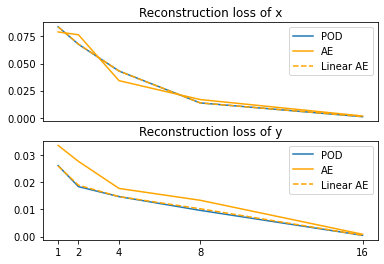

In [64]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1)

# ax1.plot(dim_x_reduct_list, mse_train_list_x_ae, '--r')
# ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, 'r')
ax1.plot(dim_x_reduct_list, mse_train_list_x_pod, label='POD')
ax1.plot(dim_x_reduct_list, mse_train_list_x_ae, color='orange',label='AE')
ax1.plot(dim_x_reduct_list, mse_train_list_x_linear_ae, '--b', color='orange', label='Linear AE')
ax1.set_title('Reconstruction loss of x')
ax1.legend()
ax1.set_xticks([])

# ax2.plot(dim_x_reduct_list, mse_train_list_y_ae, '--r', label='ae_train')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, 'r', label='ae_test')
ax2.plot(dim_x_reduct_list, mse_train_list_y_pod, label='POD')
ax2.plot(dim_x_reduct_list, mse_train_list_y_ae, color='orange',label='AE')
ax2.plot(dim_x_reduct_list, mse_train_list_y_linear_ae, '--b', color='orange', label='Linear AE')
ax2.legend()
ax2.set_xticks(dim_x_reduct_list)
ax2.set_title('Reconstruction loss of y')
# ax2.set_xlabel('Reconstruction performance under different reduced dimension')


C:\Users\ber66\AppData\Local\Temp\ipykernel_6860\863312193.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--b" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(dim_x_reduct_list, mse_test_list_x_linear_ae, '--b', color='orange', label='Linear AE')
C:\Users\ber66\AppData\Local\Temp\ipykernel_6860\863312193.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--b" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(dim_x_reduct_list, mse_test_list_y_linear_ae, '--b', color='orange', label='Linear AE')


Text(0.5, 1.0, 'Simulation error of y')

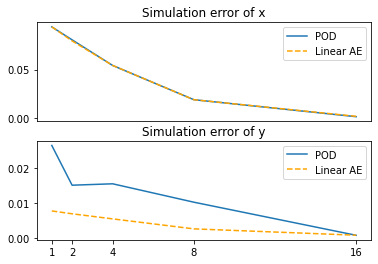

In [120]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1)

# ax1.plot(dim_x_reduct_list, mse_train_list_x_ae, '--r')
# ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, 'r')
ax1.plot(dim_x_reduct_list, mse_test_list_x_pod, label='POD')
# ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, color='orange',label='AE')
ax1.plot(dim_x_reduct_list, mse_test_list_x_linear_ae, '--b', color='orange', label='Linear AE')
ax1.set_title('Simulation error of x')
ax1.legend()
ax1.set_xticks([])

# ax2.plot(dim_x_reduct_list, mse_train_list_y_ae, '--r', label='ae_train')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, 'r', label='ae_test')
ax2.plot(dim_x_reduct_list, mse_test_list_y_pod, label='POD')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, color='orange',label='AE')
ax2.plot(dim_x_reduct_list, mse_test_list_y_linear_ae, '--b', color='orange', label='Linear AE')
ax2.legend()
ax2.set_xticks(dim_x_reduct_list)
ax2.set_title('Simulation error of y')
# plt.title('Simulation error under different reduced dimension')


Text(0.5, 1.0, 'Simulation error of y')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


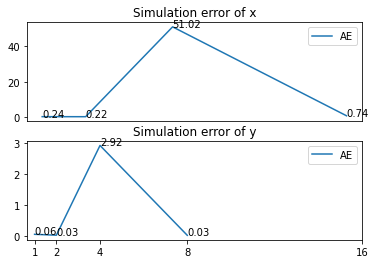

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# ax1.plot(dim_x_reduct_list, mse_train_list_x_ae, '--r')
# ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, 'r')
ax1.plot(dim_x_reduct_list, mse_test_list_x_ae, label='AE')
ax1.set_title('Simulation error of x')
ax1.legend()
ax1.set_xticks([])

for i, j in zip(dim_x_reduct_list, mse_test_list_x_ae):
    ax1.text(i, j, f"{j.round(2)}")

# ax2.plot(dim_x_reduct_list, mse_train_list_y_ae, '--r', label='ae_train')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, 'r', label='ae_test')
ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, label='AE')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_ae, color='orange',label='AE')
# ax2.plot(dim_x_reduct_list, mse_test_list_y_linear_ae, '--b', color='orange', label='Linear AE')
ax2.legend()
ax2.set_xticks(dim_x_reduct_list)
for i, j in zip(dim_x_reduct_list, mse_test_list_y_ae):
    ax2.text(i, j, f"{j.round(2)}")
ax2.set_title('Simulation error of y')

In [69]:
mse_test_list_y_ae

[0.061020920375804415,
 0.03224221178559434,
 2.9195380619389546,
 0.028964720817684336,
 nan]

In [49]:
mse_test_list_y_ae

[0.141322423646565]

In [50]:
mse_test_list_y_linear_ae

[0.14130919074786052,
 0.06660319560394298,
 0.04238281754769365,
 0.012625316426766401,
 0.0035585828455088654]